In [4]:
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

In [5]:
tf.__version__

'2.12.0'

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

lr_dir = "/Users/shreehari/Documents/project_Demo/dummycode/lrvedai"
hr_dir = "/Users/shreehari/Documents/project_Demo/dummycode/hrvedai"

lr_images = sorted(glob(lr_dir+'/*.*'))
hr_images = sorted(glob(hr_dir+'/*.*'))

lr_ds = tf.data.Dataset.from_tensor_slices(lr_images)
lr_ds = lr_ds.map(tf.io.read_file)
lr_ds = (lr_ds.map(lambda x: tf.image.decode_png(x, channels=3),
                  num_parallel_calls=AUTOTUNE)
              .cache())

hr_ds = tf.data.Dataset.from_tensor_slices(hr_images)
hr_ds = hr_ds.map(tf.io.read_file)
hr_ds = (hr_ds.map(lambda x: tf.image.decode_png(x, channels=3),
                  num_parallel_calls=AUTOTUNE)
              .cache())

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [7]:
def random_crop(lr_img, hr_img):
  hr_crop_size=256; scale=4
  lr_crop_size = 64
  lr_img_shape = tf.shape(lr_img)[:2]

  lr_w = tf.random.uniform(shape=(), 
                           maxval=lr_img_shape[1] - lr_crop_size + 1, 
                           dtype=tf.int32)
  lr_h = tf.random.uniform(shape=(), 
                           maxval=lr_img_shape[0] - lr_crop_size + 1, 
                           dtype=tf.int32)

  hr_w = lr_w * scale
  hr_h = lr_h * scale
  lr_img_crop = lr_img[lr_h:lr_h + lr_crop_size, 
                          lr_w:lr_w + lr_crop_size]
  hr_img_crop = hr_img[hr_h:hr_h + hr_crop_size, 
                          hr_w:hr_w + hr_crop_size]

  return lr_img_crop, hr_img_crop


def random_flip(lr_img, hr_img):
  rn = tf.random.uniform(shape=(), maxval=1)
  return tf.cond(rn < 0.5,
                  lambda: (lr_img, hr_img),
                  lambda: (tf.image.flip_left_right(lr_img),
                          tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
  rn = tf.random.uniform(shape=(), 
                         maxval=4, dtype=tf.int32)
  return (tf.image.rot90(lr_img, rn), 
          tf.image.rot90(hr_img, rn))

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

train_ds = tf.data.Dataset.zip((lr_ds, hr_ds))
train_ds = train_ds.map(lambda lr, hr: random_crop(lr, hr), 
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(random_rotate, 
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(random_flip, 
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def normalize(x):
  return (x - DIV2K_RGB_MEAN) / 127.5


def denormalize(x):
  return x * 127.5 + DIV2K_RGB_MEAN


def residual_block(inp):
  """Creates an EDSR residual block."""
  x = Conv2D(64, 3, padding='same', activation='relu')(inp)
  x = Conv2D(64, 3, padding='same')(x)
  x = Add()([inp, x])
  return x


def edsr_model_arch(num_residual_blocks):
    """Creates an EDSR model."""
    inp = Input(shape=(None, None, 3))
    x = Lambda(normalize)(inp)

    x = rb = Conv2D(64, 3, padding='same')(x)
    for i in range(num_residual_blocks):
        rb = residual_block(rb)
    rb = Conv2D(64, 3, padding='same')(rb)
    x = Add()([x, rb])

    x = Conv2D(64 * (3 ** 2), 3, padding='same')(x)
    x = Lambda(lambda x: tf.nn.depth_to_space(x, 4))(x)

    # x = Conv2D(64 * (3 ** 2), 3, padding='same', activation='relu')(x)
    # x = Lambda(lambda x: tf.nn.depth_to_space(x, 3))(x)

    # Adjust the size of the final convolutional layer
    x = Conv2D(3, 3, padding='same')(x)

    out = Lambda(denormalize)(x)

    return Model(inp, out, name="edsr_model")


In [10]:
edsr_model = edsr_model_arch(num_residual_blocks=16)

In [11]:
edsr_model.summary()

Model: "edsr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['lambda[0][0]']                 
                                64)                                                      

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

optim = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000, 400000], 
                                                       values=[1e-4, 5e-5, 2.5e-5]))
edsr_model.compile(optimizer=optim, loss='mean_absolute_error')

In [13]:
history = edsr_model.fit(train_ds, epochs=100, steps_per_epoch=50)

Epoch 1/100


2023-11-25 13:26:39.929263: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


50/50 [==============================] - 13s 182ms/step - loss: 29.1259
Epoch 2/100
50/50 [==============================] - 9s 188ms/step - loss: 14.4655
Epoch 3/100
50/50 [==============================] - 10s 202ms/step - loss: 11.0807
Epoch 4/100
50/50 [==============================] - 10s 197ms/step - loss: 10.8994
Epoch 5/100
50/50 [==============================] - 10s 190ms/step - loss: 9.1515
Epoch 6/100
50/50 [==============================] - 9s 186ms/step - loss: 8.9325
Epoch 7/100
50/50 [==============================] - 9s 189ms/step - loss: 9.1216
Epoch 8/100
50/50 [==============================] - 10s 198ms/step - loss: 8.2743
Epoch 9/100
50/50 [==============================] - 10s 192ms/step - loss: 8.6706
Epoch 10/100
50/50 [==============================] - 10s 199ms/step - loss: 7.9592
Epoch 11/100
50/50 [==============================] - 10s 191ms/step - loss: 8.0466
Epoch 12/100
50/50 [==============================] - 10s 195ms/step - loss: 8.3710
Epoch 13/100

Text(0.5, 1.0, 'Loss History')

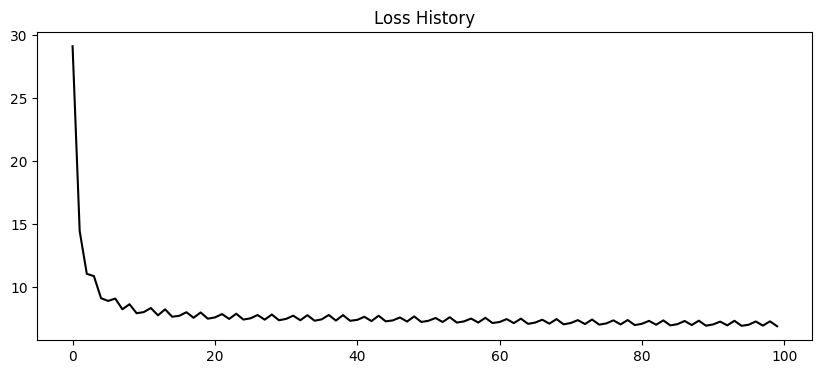

In [14]:
f, ax = plt.subplots(1, figsize=(10, 4))

epochs = history.epoch
# learning_rates = [optim.lr(e*1000).numpy() for e in epochs]
losses = history.history['loss']

# plt.subplot(121)
# plt.plot(epochs, learning_rates, 'k--')
# plt.title('Learning Rate History')
plt.plot(epochs, losses, 'k')
plt.title('Loss History')

(<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[ 51.,  63.,  59.],
        [ 72.,  87.,  82.],
        [ 83.,  98.,  95.],
        ...,
        [ 98., 112., 113.],
        [ 94., 113., 107.],
        [ 98., 119., 110.]],

       [[ 63.,  75.,  71.],
        [ 75.,  87.,  83.],
        [ 73.,  88.,  85.],
        ...,
        [ 79.,  91.,  89.],
        [ 87., 102.,  95.],
        [ 98., 116., 104.]],

       [[ 71.,  82.,  76.],
        [ 72.,  85.,  78.],
        [ 77.,  89.,  85.],
        ...,
        [ 65.,  76.,  70.],
        [ 81.,  91.,  80.],
        [ 93., 101.,  86.]],

       ...,

       [[ 65.,  68.,  47.],
        [ 70.,  73.,  54.],
        [ 75.,  79.,  62.],
        ...,
        [ 26.,  42.,  29.],
        [ 49.,  65.,  52.],
        [ 38.,  54.,  41.]],

       [[ 74.,  78.,  55.],
        [ 79.,  82.,  61.],
        [ 74.,  78.,  63.],
        ...,
        [ 46.,  60.,  47.],
        [ 45.,  61.,  50.],
        [ 46.,  62.,  51.]],

       [[ 78.,  82

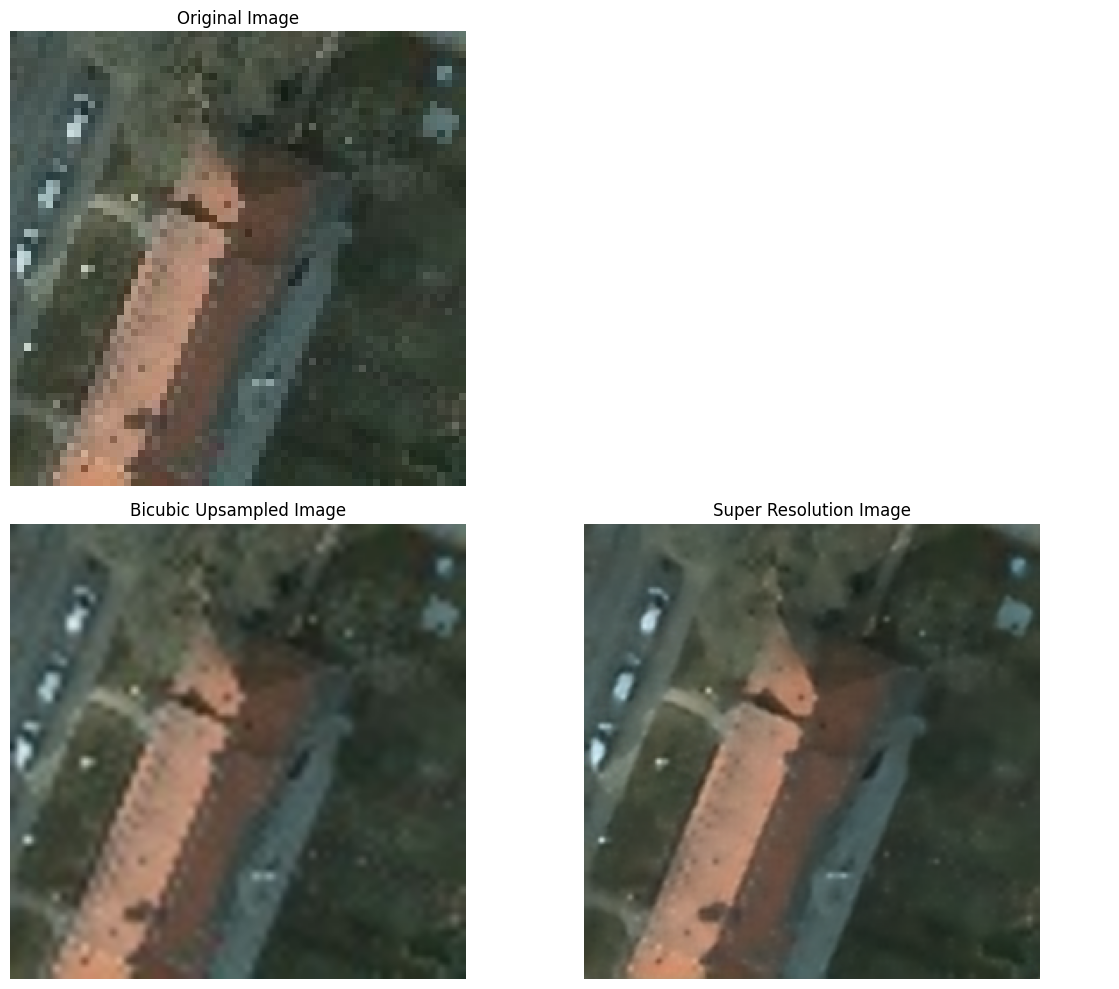

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

def run_sr_inference(img_path, model):
    lr_file = tf.io.read_file(img_path)
    lr_img = tf.image.decode_png(lr_file, channels=3)
    lr_img_npy = lr_img.numpy()

    upsamp_img = (np.asarray(
                Image.fromarray(lr_img_npy)
                     .resize(size=(lr_img_npy.shape[1]*3, 
                                   lr_img_npy.shape[0]*3), 
                             resample=Image.BICUBIC)))
  
    lr_img = tf.expand_dims(lr_img, axis=0)
    lr_img = tf.cast(lr_img, tf.float32)
    sr_img = model(lr_img)
    sr_img = tf.clip_by_value(sr_img, 0, 255)
    sr_img = tf.cast(sr_img, tf.uint8)

    trg_img_path = img_path.replace("val_LR", "val_HR")
    trg_file = tf.io.read_file(trg_img_path)
    trg_img = tf.image.decode_png(trg_file, channels=3)
    trg_img_npy = trg_img.numpy()
    trg_img = tf.expand_dims(trg_img, axis=0)
    trg_img = tf.cast(trg_img, tf.float32)

    return lr_img[0], upsamp_img, sr_img[0], trg_img[0]

# Update the plot_edsr_results function
def plot_edsr_results(orig, bicubic, super_res):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    plt.subplot(221)
    plt.imshow(orig.numpy().astype(np.uint8)/255.)  # Convert to np.uint8
    plt.title('Original Image')
    plt.axis("off")
    plt.subplot(222)
    plt.axis("off")
    plt.subplot(223)
    plt.imshow(bicubic.astype(np.uint8))  # Convert to np.uint8
    plt.title('Bicubic Upsampled Image')
    plt.axis("off")
    plt.subplot(224)
    plt.imshow(super_res.numpy().astype(np.uint8)/255.)  # Convert to np.uint8
    plt.title('Super Resolution Image')
    plt.axis("off")
    fig.tight_layout()

# Update the following code
lr_img_loc = "/Users/shreehari/Documents/project_Demo/dummycode/lrvedai/20.jpg"
result = run_sr_inference(lr_img_loc, edsr_model)
print(result)

# Assuming `run_sr_inference` returns a tuple of four values
if len(result) == 4:
    lr, upsamp, sr, trg = result
    plot_edsr_results(lr, upsamp, sr)
    print(lr, upsamp, sr, trg)
else:
    print(len(result))


In [22]:
edsr_model.save_weights('edsr_16-res-block-x4.h5')



In [23]:
from tensorflow.keras.models import save_model
save_model(edsr_model, "newmodel.h5")

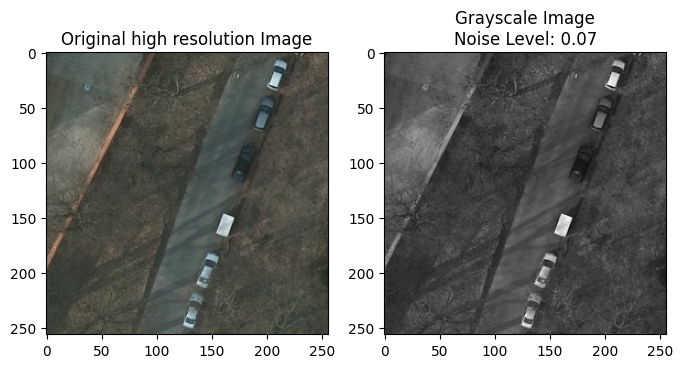

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util

# Load the image
image_path = "/Users/shreehari/Documents/project_Demo/dummycode/hrvedai/40.jpg"
image = io.imread(image_path)

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Calculate the noise levels (standard deviation) using NumPy
noise_level = np.std(gray_image)

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original high resolution Image")

# Display the grayscale image
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap="gray")
plt.title(f"Grayscale Image\nNoise Level: {noise_level:.2f}")

plt.show()


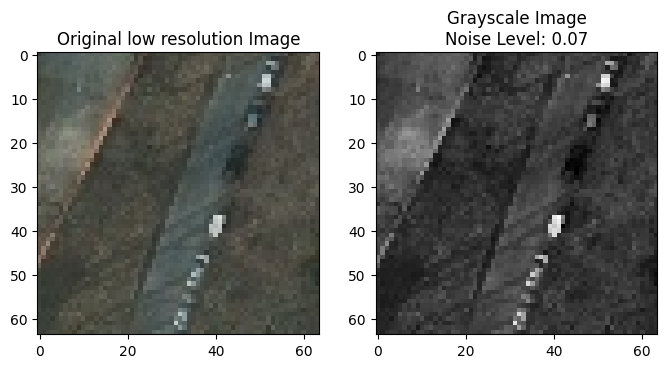

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util

# Load the image
image_path = "/Users/shreehari/Documents/project_Demo/dummycode/lrvedai/40.jpg"
image = io.imread(image_path)

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Calculate the noise levels (standard deviation) using NumPy
noise_level = np.std(gray_image)

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original low resolution Image")

# Display the grayscale image
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap="gray")
plt.title(f"Grayscale Image\nNoise Level: {noise_level:.2f}")

plt.show()


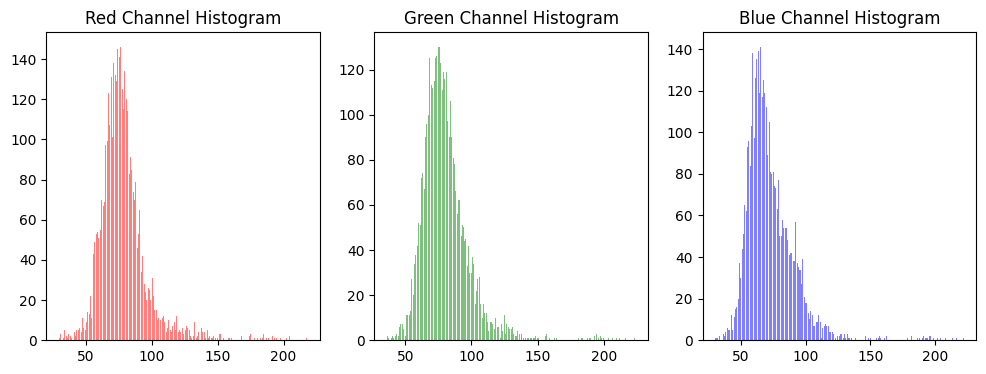

In [30]:
import matplotlib.pyplot as plt
from skimage import io, color

# Load the image
image_path = "/Users/shreehari/Documents/project_Demo/dummycode/lrvedai/40.jpg"
image = io.imread(image_path)

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Plot histograms
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(image[:, :, 0].ravel(), bins=256, color='red', alpha=0.5)
plt.title('Red Channel Histogram')

plt.subplot(1, 3, 2)
plt.hist(image[:, :, 1].ravel(), bins=256, color='green', alpha=0.5)
plt.title('Green Channel Histogram')

plt.subplot(1, 3, 3)
plt.hist(image[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5)
plt.title('Blue Channel Histogram')

plt.show()


In [31]:
from tensorflow.keras.layers import BatchNormalization, \
          Conv2D, Dense, Flatten, Input, LeakyReLU, Lambda
from tensorflow.keras.models import Model

def minmax_normalize(x):
  """Normalizes RGB images to [-1, 1]."""
  return x / 127.5 - 1


def srgan_discriminator_arch():
  hr_size=256
  inp = Input(shape=(hr_size, hr_size, 3))
  x = Lambda(minmax_normalize)(inp)

  x = Conv2D(filters=64, kernel_size=3, 
             strides=1, padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(filters=64, kernel_size=3, 
             strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.8)(x)           
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=128, kernel_size=3, 
             strides=1, padding='same')(x)
  x = BatchNormalization(momentum=0.8)(x)           
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(filters=128, kernel_size=3, 
             strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.8)(x)           
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=256, kernel_size=3, 
             strides=1, padding='same')(x)
  x = BatchNormalization(momentum=0.8)(x)           
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(filters=256, kernel_size=3, 
             strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.8)(x)           
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=512, kernel_size=3, 
             strides=1, padding='same')(x)
  x = BatchNormalization(momentum=0.8)(x)           
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(filters=512, kernel_size=3, 
             strides=2, padding='same')(x)
  x = BatchNormalization(momentum=0.8)(x)           
  x = LeakyReLU(alpha=0.2)(x)

  x = Flatten()(x)
  x = Dense(1024)(x)
  x = LeakyReLU(alpha=0.2)(x)
  out = Dense(1, activation='sigmoid')(x)

  return Model(inp, out)

In [32]:
generator = edsr_model_arch(num_residual_blocks=16)
generator.load_weights('edsr_16-res-block-x4.h5')

discriminator = srgan_discriminator_arch()

In [33]:
generator.summary()

Model: "edsr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda_3 (Lambda)              (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   1792        ['lambda_3[0][0]']               
                                64)                                                      

In [34]:
tf.keras.utils.plot_model(generator, show_shapes=True, 
                          rankdir='TB')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [35]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda_6 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 conv2d_72 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_73 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                             

In [36]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, 
                          rankdir='TB')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

lr_schedule = PiecewiseConstantDecay(boundaries=[100000, 200000], 
                                     values=[1e-4, 1e-5, 5e-6])
generator_optim = Adam(learning_rate=lr_schedule)
discriminator_optim = Adam(learning_rate=lr_schedule)

In [38]:
from tensorflow.keras.applications import vgg19

vgg = vgg19.VGG19(input_shape=(None, None, 3), 
                  weights='imagenet',
                  include_top=False)
cutvgg_model = Model(vgg.input, vgg.layers[20].output)

cutvgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [39]:
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

def compute_generator_loss(sr_pred):
  return bce_loss(tf.ones_like(sr_pred), sr_pred)

def compute_discriminator_loss(hr_pred, sr_pred):
  hr_loss = bce_loss(tf.ones_like(hr_pred), hr_pred)
  sr_loss = bce_loss(tf.zeros_like(sr_pred), sr_pred)
  return hr_loss + sr_loss

@tf.function
def compute_content_loss(hr, sr):
  hr = vgg19.preprocess_input(hr)
  sr = vgg19.preprocess_input(sr)
  hr_deep_features = cutvgg_model(hr) / 12.75
  sr_deep_features = cutvgg_model(sr) / 12.75
  return mse_loss(hr_deep_features, sr_deep_features)

In [40]:
@tf.function
def train_step(lr_img_batch, hr_img_batch):
  """SRGAN training step.
  
  Takes an LR and an HR image batch as input and returns
  the computed perceptual loss and discriminator loss.
  """
  with tf.GradientTape() as gen_tape,\
          tf.GradientTape() as disc_tape:
    lr_img_batch = tf.cast(lr_img_batch, tf.float32)
    hr_img_batch = tf.cast(hr_img_batch, tf.float32)

    # Forward pass
    sr_gen_batch = generator(lr_img_batch, training=True)
    hr_pred = discriminator(hr_img_batch, training=True)
    sr_pred = discriminator(sr_gen_batch, training=True)

    # Compute losses
    content_loss = compute_content_loss(hr_img_batch, 
                                        sr_gen_batch)
    gen_loss = compute_generator_loss(sr_pred)
    perceptual_loss = content_loss + 1e-3 * gen_loss
    disc_loss = compute_discriminator_loss(hr_pred, sr_pred)

  # Compute gradient of perceptual loss w.r.t. generator weights 
  gen_grads = gen_tape.gradient(perceptual_loss, 
                                generator.trainable_variables)
  # Compute gradient of discriminator loss w.r.t. discriminator weights 
  disc_grads = disc_tape.gradient(disc_loss, 
                                  discriminator.trainable_variables)

  # Update weights of generator and discriminator
  generator_optim.apply_gradients(zip(gen_grads, 
                                      generator.trainable_variables))
  discriminator_optim.apply_gradients(zip(disc_grads, 
                                          discriminator.trainable_variables))

  return perceptual_loss, disc_loss

In [41]:
total_steps = 20
step = 0
pl_batch = []
dl_batch = []
for lr_batch, sr_batch in tqdm(train_ds.take(total_steps)):
  pl, dl = train_step(lr_batch, sr_batch)
  pl_batch.append(pl)
  dl_batch.append(dl)
  step += 1

  if step % 5 == 0:
    print('Step: {step}/{steps}: Perceptual Loss: {ploss:.5f}, Discriminator Loss: {dloss:.5f}'.format(
        step=step, steps=total_steps,
        ploss=np.mean(pl_batch),
        dloss=np.mean(dl_batch)
    ))
    pl_batch = []
    dl_batch = []

 25%|██▌       | 5/20 [00:34<01:07,  4.49s/it]

Step: 5/20: Perceptual Loss: 0.07913, Discriminator Loss: 19.81397


 50%|█████     | 10/20 [00:46<00:27,  2.71s/it]

Step: 10/20: Perceptual Loss: 0.07839, Discriminator Loss: 10.07770


 75%|███████▌  | 15/20 [00:59<00:12,  2.58s/it]

Step: 15/20: Perceptual Loss: 0.07175, Discriminator Loss: 4.78702


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]

Step: 20/20: Perceptual Loss: 0.07621, Discriminator Loss: 5.41505


In [42]:
generator.save_weights('srgan_finetuned_edsr_16-res-block-x4.h5')

In [43]:
#LOAD MODEL AND WEIGHTS
weight_edsr = "edsr_16-res-block-x4.h5"
weight_srgan = "srgan_finetuned_edsr_16-res-block-x4.h5"


edsr_orig_model = edsr_model_arch(num_residual_blocks=16)
edsr_orig_model.load_weights(weight_edsr)

edsr_finetuned_model = edsr_model_arch(num_residual_blocks=16)
edsr_finetuned_model.load_weights(weight_srgan)

(<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[52., 70., 74.],
        [50., 68., 72.],
        [50., 68., 72.],
        ...,
        [56., 62., 58.],
        [60., 66., 64.],
        [54., 60., 58.]],

       [[49., 67., 71.],
        [52., 70., 74.],
        [48., 66., 70.],
        ...,
        [53., 59., 55.],
        [50., 56., 54.],
        [59., 65., 63.]],

       [[49., 67., 69.],
        [53., 71., 73.],
        [54., 72., 76.],
        ...,
        [57., 63., 59.],
        [52., 58., 56.],
        [58., 64., 62.]],

       ...,

       [[48., 55., 48.],
        [47., 54., 47.],
        [67., 76., 71.],
        ...,
        [80., 81., 67.],
        [83., 84., 70.],
        [74., 75., 61.]],

       [[41., 51., 43.],
        [65., 75., 67.],
        [73., 82., 77.],
        ...,
        [82., 83., 69.],
        [85., 86., 72.],
        [84., 85., 71.]],

       [[44., 54., 46.],
        [79., 89., 81.],
        [68., 77., 72.],
        ...,
        [78., 79., 6

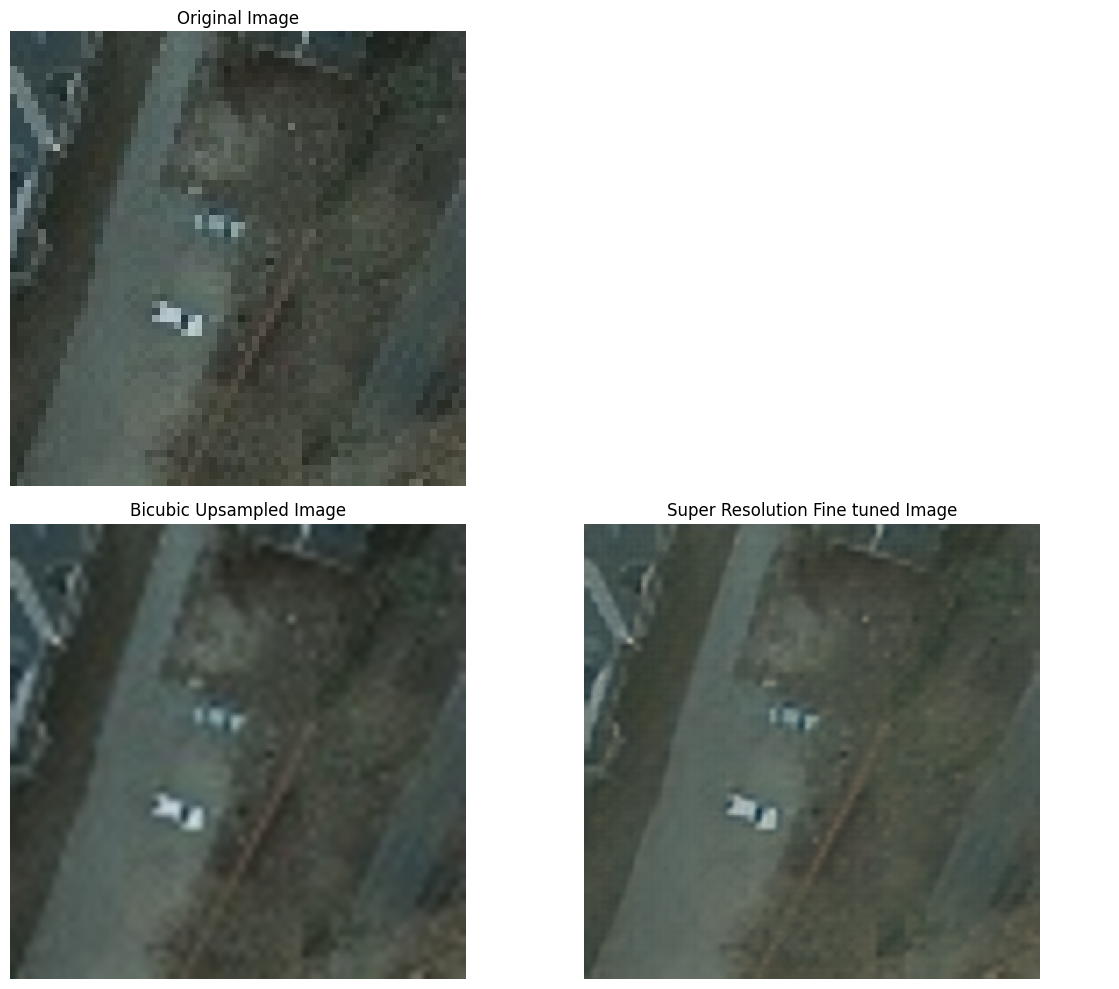

In [45]:
from PIL import Image
import matplotlib.pyplot as plt

def run_sr_inference(img_path, model):
    lr_file = tf.io.read_file(img_path)
    lr_img = tf.image.decode_png(lr_file, channels=3)
    lr_img_npy = lr_img.numpy()

    upsamp_img = (np.asarray(
                Image.fromarray(lr_img_npy)
                     .resize(size=(lr_img_npy.shape[1]*3, 
                                   lr_img_npy.shape[0]*3), 
                             resample=Image.BICUBIC)))
  
    lr_img = tf.expand_dims(lr_img, axis=0)
    lr_img = tf.cast(lr_img, tf.float32)
    sr_img = model(lr_img)
    sr_img = tf.clip_by_value(sr_img, 0, 255)
    sr_img = tf.cast(sr_img, tf.uint8)

    trg_img_path = img_path.replace("val_LR", "val_HR")
    trg_file = tf.io.read_file(trg_img_path)
    trg_img = tf.image.decode_png(trg_file, channels=3)
    trg_img_npy = trg_img.numpy()
    trg_img = tf.expand_dims(trg_img, axis=0)
    trg_img = tf.cast(trg_img, tf.float32)

    return lr_img[0], upsamp_img, sr_img[0], trg_img[0]

# Update the plot_edsr_results function
def plot_edsr_results(orig, bicubic, super_res):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    plt.subplot(221)
    plt.imshow(orig.numpy().astype(np.uint8)/255.)  # Convert to np.uint8
    plt.title('Original Image')
    plt.axis("off")
    plt.subplot(222)
    plt.axis("off")
    plt.subplot(223)
    plt.imshow(bicubic.astype(np.uint8))  # Convert to np.uint8
    plt.title('Bicubic Upsampled Image')
    plt.axis("off")
    plt.subplot(224)
    plt.imshow(super_res.numpy().astype(np.uint8)/255.)  # Convert to np.uint8
    plt.title('Super Resolution Fine tuned Image')
    plt.axis("off")
    fig.tight_layout()

# Update the following code
lr_img_loc = "/Users/shreehari/Documents/project_Demo/dummycode/lrvedai/36.jpg"
result = run_sr_inference(lr_img_loc, generator)
print(result)

# Assuming `run_sr_inference` returns a tuple of four values
if len(result) == 4:
    lr, upsamp, sr, trg = result
    plot_edsr_results(lr, upsamp, sr)
    print(lr, upsamp, sr, trg)
else:
    print(len(result))
